In [1]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 

In [3]:
path = "/fast_scratch/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

### Plot the histogram of the two observables
    1. Sum of charges in an event
    2. Number of PMTs hit

### 1. Sum of charges in an event

In [30]:
train_batch_size = 1024
dset=WCH5Dataset(path, 0.1, 0.1, reduced_dataset_size=300000)

train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          num_workers=4, sampler=SubsetRandomSampler(dset.train_indices))

In [31]:
event_charges = []
event_timings = []

labels = []

for data in iter(train_loader):
    event_charges.append(data[0][:,:,:,:19].numpy())
    event_timings.append(data[0][:,:,:,19:].numpy())
    
    labels.append(data[1].numpy())

In [32]:
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)
print(len(labels), labels[0].shape)

235 (1024, 40, 40, 19) 235 (1024, 40, 40, 19)
235 (1024,)


In [33]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

In [34]:
labels = np.concatenate(labels, axis=0)

In [35]:
print(event_charges.shape, event_timings.shape, labels.shape)

(240000, 40, 40, 19) (240000, 40, 40, 19) (240000,)


### Distrbution of the labels

In [36]:
print(Counter(labels))

Counter({0: 80930, 1: 79829, 2: 79241})


In [37]:
sum_event_charges = np.sum(event_charges.reshape(event_charges.shape[0], -1), axis=1)
sum_event_timings = np.sum(event_timings.reshape(event_timings.shape[0], -1), axis=1)

In [38]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

In [39]:
print(sum_event_charges.shape, sum_event_timings.shape)

(240000,) (240000,)


### Plot the per event sum charge distribution

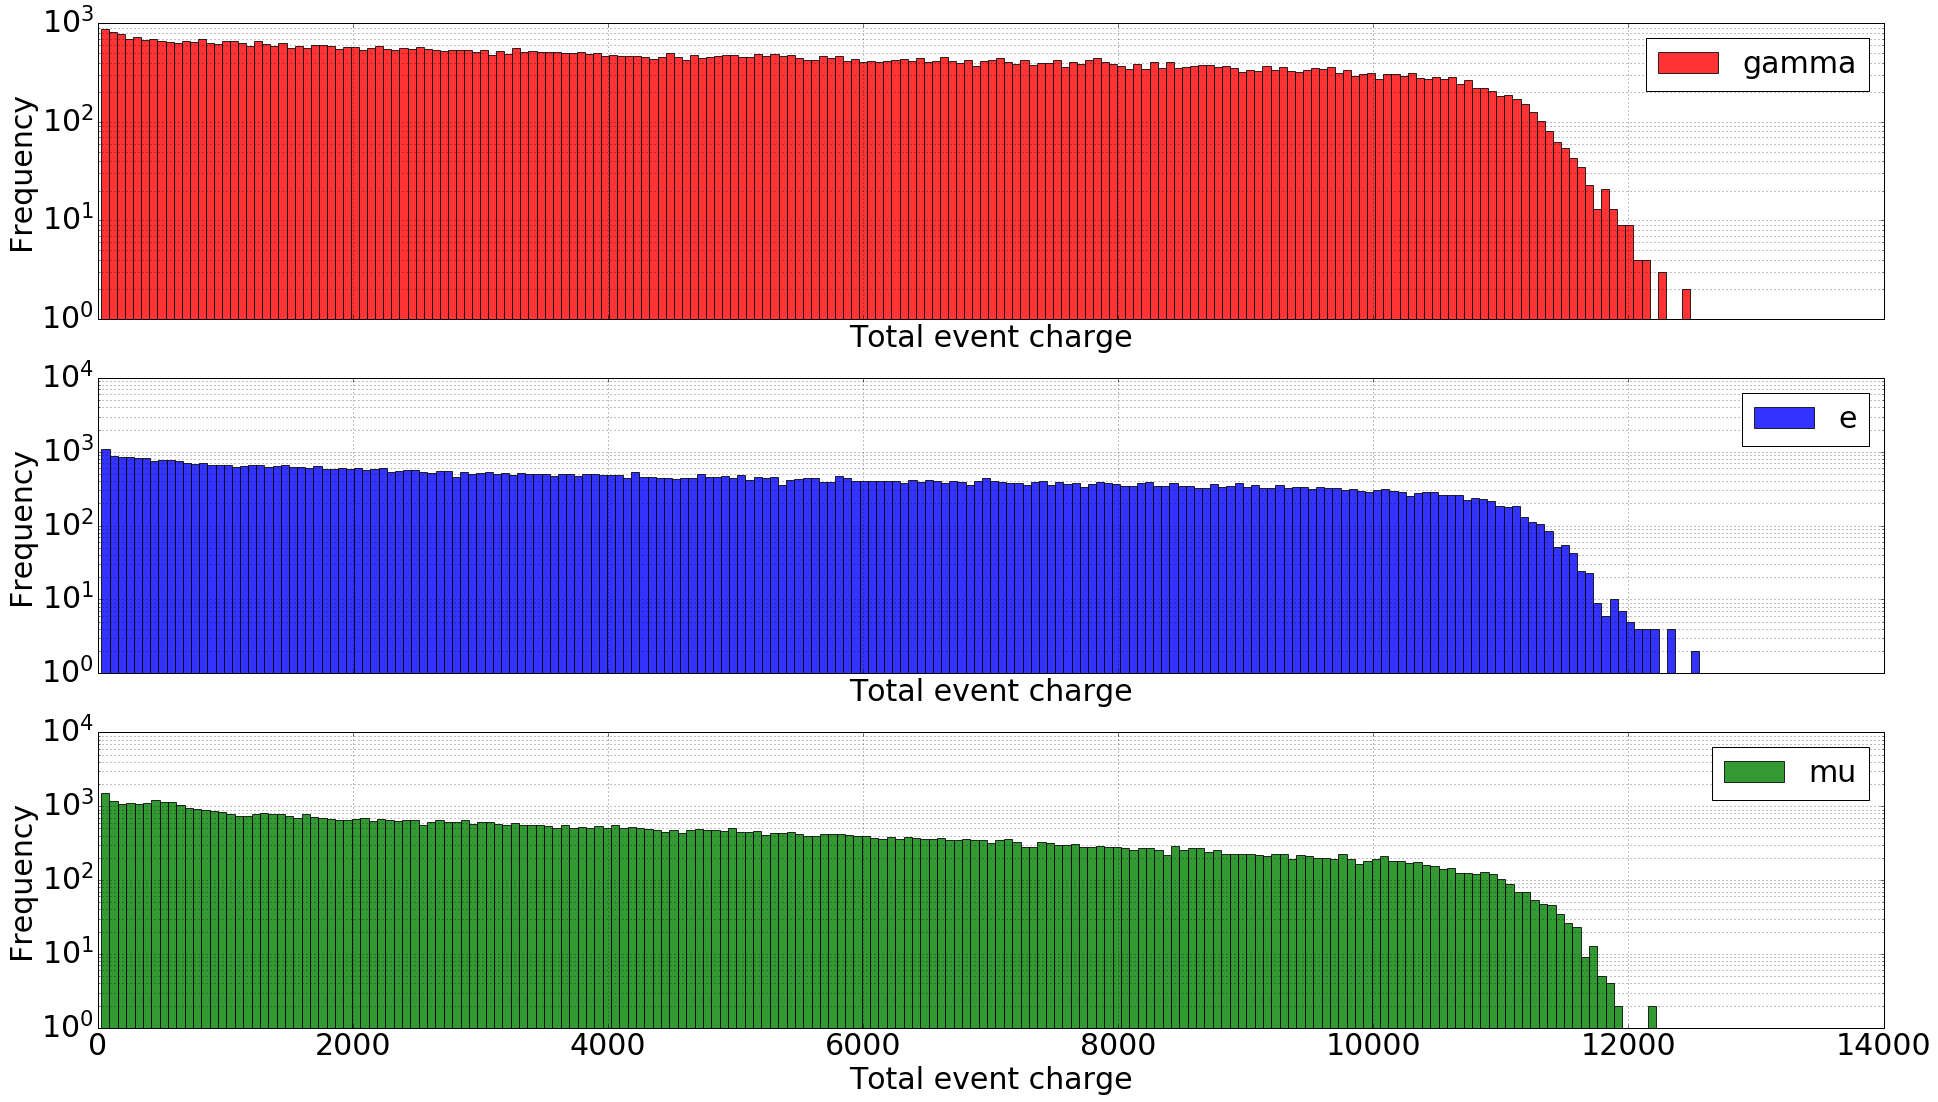

In [40]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = sum_event_charges[labels == label].flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("Total event charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

### 2. Number of PMTs hit in an event

### PMT charge distribution in a single event

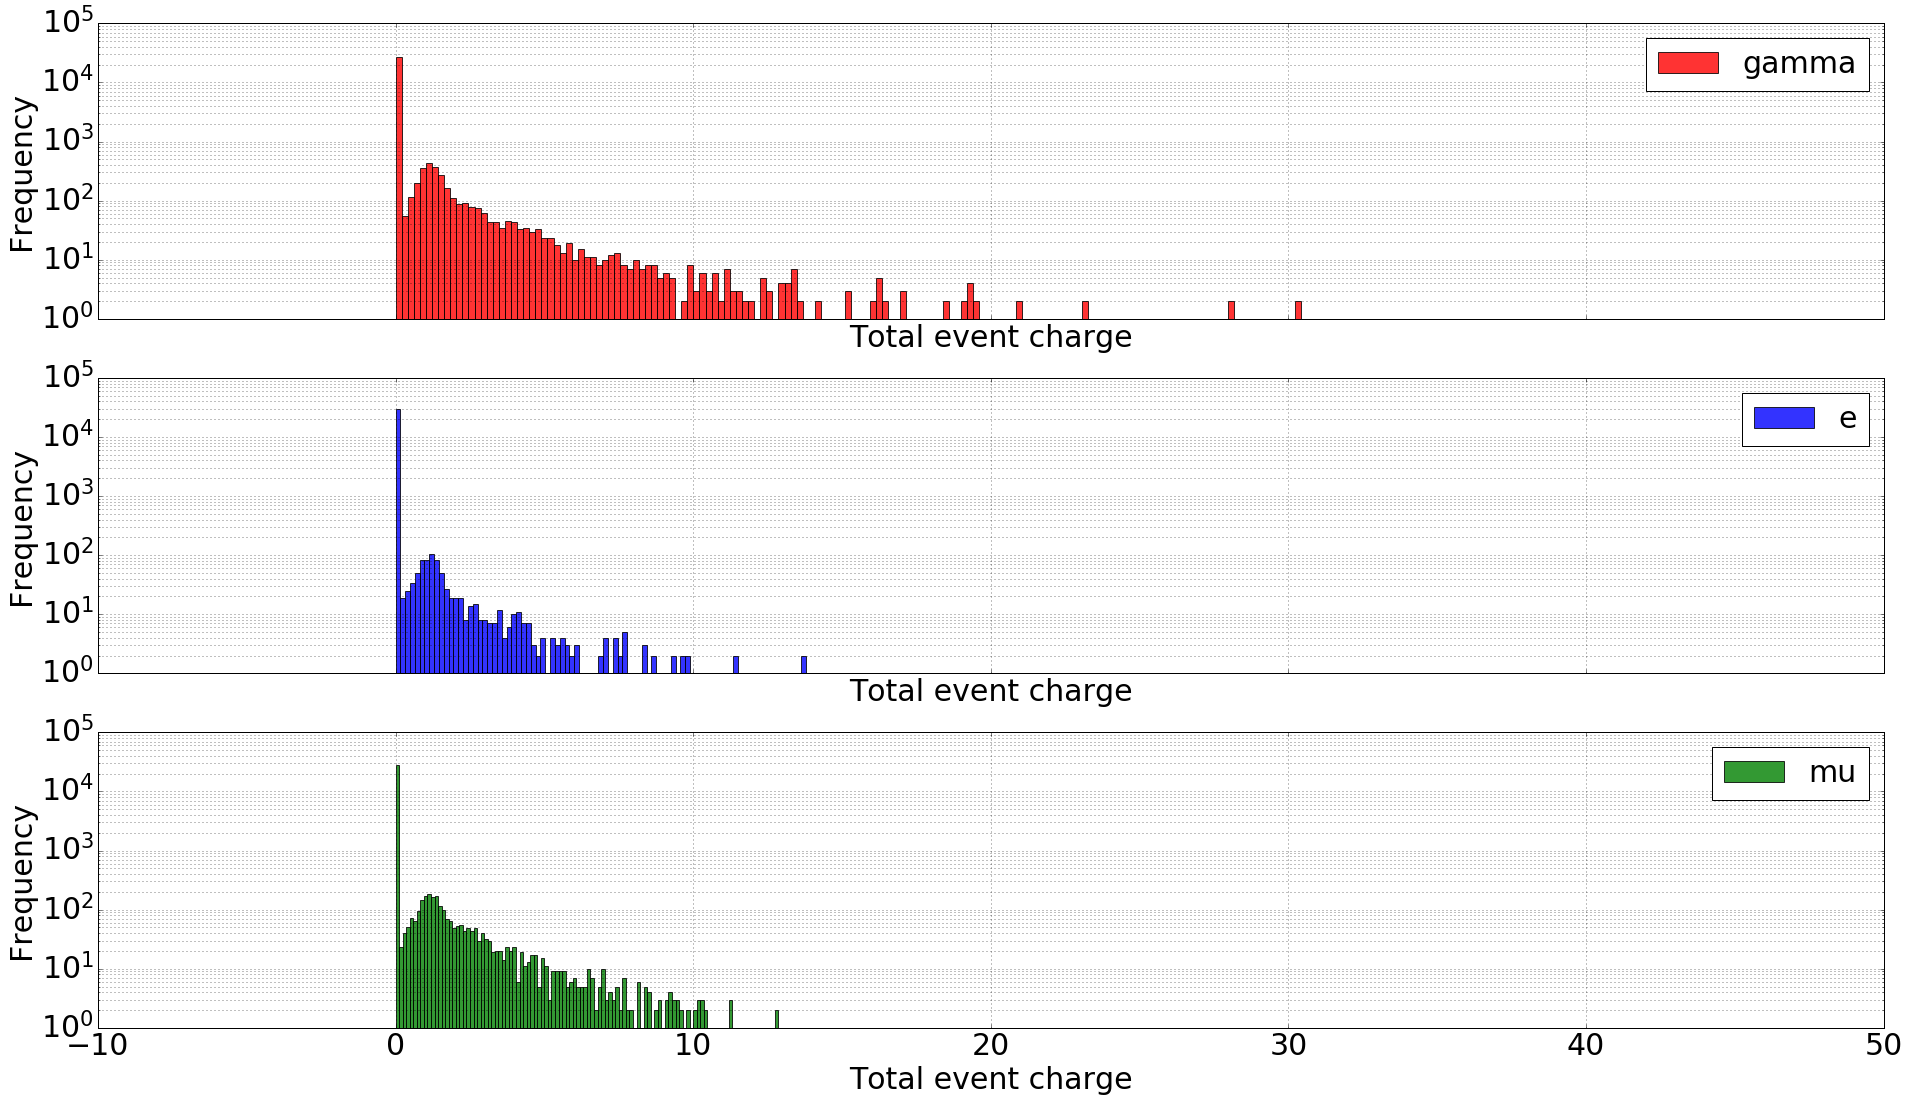

In [42]:
event_charge_dict = {}
for label in label_dict.keys():
    label_events = event_charges[labels == label]
    label_events = label_events.reshape(label_events.shape[0], -1)
    event_charge_dict[label] = 
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("Total event charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

### So we will treat any non-zero charge PMT as a hit

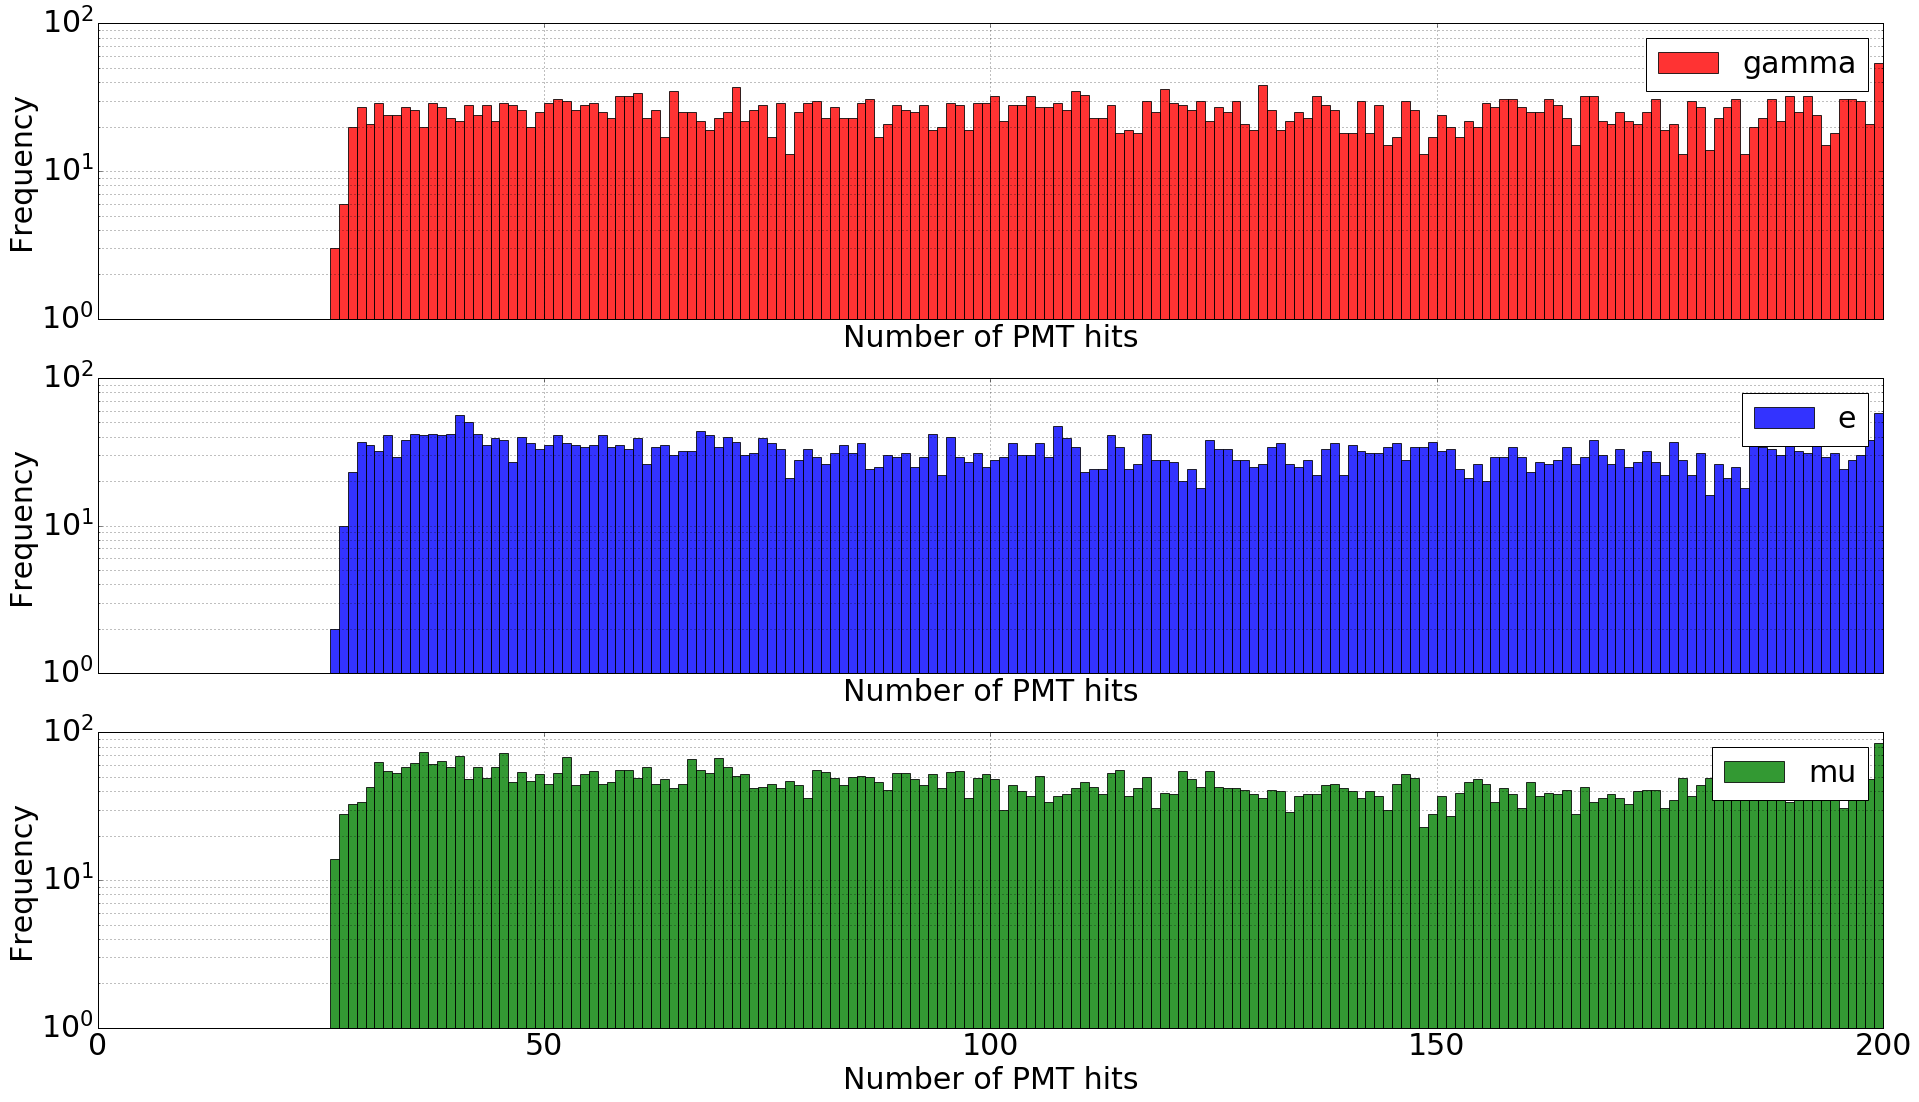

In [96]:
event_charge_dict = {}
for label in label_dict.keys():
    label_events = event_charges[labels == label]
    label_events = label_events.reshape(label_events.shape[0], -1)
    label_events = [event[event > 0] for event in label_events]
    label_events = [event.shape[0] for event in label_events]
    
    event_charge_dict[label] = label_events
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1], range=(0, 200))
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("Number of PMT hits", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_ylim(bottom=1)

### Example showing what is happening in the snippet above

In [85]:
events = event_charges[0:2]
events = events.reshape(events.shape[0], -1)

In [86]:
print(events.shape)

(2, 30400)


In [87]:
events = [event[event > 0] for event in events]
print(len(events))

2


In [88]:
print(events[0].shape, events[1].shape)

(823,) (215,)


In [89]:
events = [event.shape[0] for event in events]
print(events)

[823, 215]
